# Backtesting Project 
## CNN을 이용한 candle chart 예측

* **작성자 : 정경륜**
* **최종 작성 일자 : 2021/11/19**


## 0.기본 세팅

In [29]:
# colab 한글 폰트 설정
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [30]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [2]:
# candle chart를 그리기 위한 모듈
!pip install --upgrade mplfinance

     |████████████████████████████████| 62 kB 766 kB/s 


In [3]:
!pip install pykrx

     |████████████████████████████████| 82 kB 660 kB/s 
     |████████████████████████████████| 60 kB 7.1 MB/s 
     |████████████████████████████████| 251 kB 18.9 MB/s 


In [1]:
# 구글 드라이브 연결(colab)
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from mplfinance.original_flavor import candlestick2_ochl
import datetime as dt
import time

## 1.데이터 수집

### 1) 시가총액이 큰 종목 순으로 ticker_list에 저장

In [10]:
#오늘 날짜 구하기 : 2021-11-19
#dt_now = str(dt.datetime.now().date())
dt_now = '2021-11-19'
print(f'{dt_now} 기준')
#dt_now = ''.join(c for c in dt_now if c not in '-')

# 시가총액이 큰 순으로 나열
market_cap_df = stock.get_market_cap_by_ticker(dt_now)
market_cap_df = market_cap_df[['시가총액']]
market_cap_df = market_cap_df.sort_values(by=['시가총액'], ascending=False)
market_cap_df

2021-11-19 기준


,시가총액
티커,
005930,425048517560000
000660,81172263697500
035420,66362411580000
207940,59019180000000
035720,56603677242000
...,...
001529,2938395500
267810,2390115000
329020,1740000000


In [11]:
length = 30
higher_market_cap_df = market_cap_df.iloc[:length]
ticker_list = np.array(higher_market_cap_df.index)
ticker_list

array(['005930', '000660', '035420', '207940', '035720', '005935',
       '051910', '006400', '005380', '000270', '323410', '068270',
       '259960', '005490', '105560', '377300', '012330', '017670',
       '066570', '028260', '096770', '055550', '302440', '051900',
       '034730', '036570', '352820', '015760', '091990', '003550'],
      dtype=object)

### 2) data_cleaning 함수 

In [12]:
def data_cleansing(dataframe):
    # 1. nan값 drop
    dataframe.dropna(how='any', inplace=True)
    
    # 2. 주식 분할로 0원 처리된 구간 drop
    index_to_be_dropped = dataframe.loc[dataframe['시가']==0].index.append(
                          dataframe.loc[dataframe['고가']==0].index).append(
                          dataframe.loc[dataframe['저가']==0].index).append(
                          dataframe.loc[dataframe['종가']==0].index).append(
                          dataframe.loc[dataframe['거래량']==0].index)
    
    index_to_be_dropped = list(set(index_to_be_dropped))
    
    dataframe = dataframe.drop(index_to_be_dropped)
    return dataframe

### 3) pykrx로 추출한 dataframe preprocessing

In [13]:
# mplfinance 모듈을 사용하기 위해서 dataframe을 알맞게 전처리 하는 함수
def preprocessing_pykrx_df(pykrx_df):
  pykrx_df.index.name = 'Date'
  pykrx_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
  return pykrx_df

### 4) stock data를 얻는 함수

In [14]:
def get_stock_data(start, end, stock_code):
    dataframe = stock.get_market_ohlcv_by_date(start, end, stock_code)
    dataframe = data_cleansing(dataframe)
    dataframe = preprocessing_pykrx_df(dataframe)
    return dataframe

### 5) OHLC to Candle Stick 함수

In [15]:
def ohlc2cs(df, seq_len, dimension):
    # python preprocess.py -m ohlc2cs -l 20 -i stockdatas/EWT_testing.csv -t testing
    print("Converting olhc to candlestick.")
    plt.style.use('dark_background')

    figs = np.zeros((len(df)-1, dimension, dimension, 3))
    labels = []
    for i in range(0, len(df)-1):
        # ohlc+volume
        # c = (seq_len -1) 길이의 주가 데이터. 
        # (만약 seq_len이 20이라면 c는 19일치의 주가 데이터를 의미)
        c = df.iloc[i:i + int(seq_len) - 1, :]
        # c_ = (seq_len) 길이의 주가 데이터. 
        # (만약 seq_len이 20이라면 c_는 20일치의 주가 데이터를 의미)
        c_ = df.iloc[i:i + int(seq_len), :]
        
        # seq_len의 길이보다 짧은 데이터는 무시
        if len(c_) == int(seq_len):
            my_dpi = 96   # 해상도 지정
            fig = plt.figure(figsize=(dimension / my_dpi,
                                      dimension / my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            # Volume indicator는 제외하고 그래프를 그린다.  
            candlestick2_ochl(ax1, c['Open'], c['Close'], c['High'],
                              c['Low'], width=1,
                              colorup='#77d879', colordown='#db3f3f')
           # mpf.plot(ax1, type='candle', colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a seconds axis for the volume overlay
        
        # starting은 seq_len = 20 기준으로 19일 종가를 의미
        starting = c_["Close"].iloc[-2]
        # ending은 seq_len = 20 기준으로 20일 종가를 의미
        endvalue = c_["Close"].iloc[-1]

        # seq_len = 20을 기준으로 19일 종가에 비해 20일 종가가 상승했을 때 
        if endvalue > starting :
            label = 1   # 1로 labeling
        # seq_len = 20을 기준으로 19일 종가에 비해 20일 종가가 하락했을 때
        else :
            label = 0   # 0으로 labeling
        labels.append(label)

        fig.canvas.draw()
        fig_np = np.array(fig.canvas.renderer._renderer)
        figs[i] = fig_np[:,:,:3]

        plt.close(fig)
        # normal length - end

    print("Converting olhc to candlestick finished.")
    return figs, labels

### 6) pykrx를 이용해 data 수집 후 전처리

In [ ]:
# 데이터 수집
starting = '20100101'    # 데이터 수집 시작 날짜
ending = '20211119'   # 데이터 수집 종료 날짜
stock_code = ticker_list[0]     

seq_len = 20    # candle chart 일수 지정
dimension = 48    # 이미지 크기
p=1   # processing 과정 표기 변수

stock_df = get_stock_data(starting, ending, stock_code)
print(f'{ticker_list[0]} processing... {p}/{length}')

# candle chart 생성
figures, labels = ohlc2cs(stock_df, seq_len, dimension)
#위 함수로 생성된 figures는 값의 범위가 0~255 이기 때문에 0~1로 맞춰주기 위해 255로 나눈다.
# Scaling을 하는 이유는 픽셀 값의 차이가 너무 많이 나면 모델의 성능이 좋지 않을 수 있기 때문이다. 
figures = figures/255.0
print(np.shape(labels), np.shape(figures))

train_len = int(len(labels) * 0.8)
X_train, y_train = figures[:train_len], labels[:train_len]
X_test, y_test = figures[train_len:], labels[train_len:]

for ticker in ticker_list[1:]:
    p += 1
    try:
      stock_df = get_stock_data(starting, ending, ticker)
      print(f'{ticker} processing... {p}/{length}')
    
      figures, labels = ohlc2cs(stock_df, seq_len, dimension)
      #위 함수로 생성된 figures는 값의 범위가 0~255 이기 때문에 0~1로 맞춰주기 위해 255로 나눕니다.
      figures = figures/255.0
      print(np.shape(labels), np.shape(figures))

      train_len = int(len(labels) * 0.8)
      X_data, y_data = figures[:train_len], labels[:train_len]
      X_train = np.append(X_train, X_data, axis=0)
      y_train = np.append(y_train, y_data, axis=0)
      X_data, y_data = figures[train_len:], labels[train_len:]
      X_test = np.append(X_test, X_data, axis=0)
      y_test = np.append(y_test, y_data, axis=0)

      # 데이터 전처리 과정이 오래 걸리기 때문에 저장을 해둔다. 
      np.save('/content/gdrive/My Drive/Colab Notebooks/saved_X_train', X_train)
      np.save('/content/gdrive/My Drive/Colab Notebooks/saved_y_train', y_train)
      np.save('/content/gdrive/My Drive/Colab Notebooks/saved_X_test', X_test)
      np.save('/content/gdrive/My Drive/Colab Notebooks/saved_y_test', y_test)
      print(f'{p}번 {ticker} 저장완료')

    except:
      print(f'{ticker} failed.. ')

005930 processing... 1/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2929,) (2929, 48, 48, 3)
000660 processing... 2/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2932,) (2932, 48, 48, 3)
2번 000660 저장완료
035420 processing... 3/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2908,) (2908, 48, 48, 3)
3번 035420 저장완료
207940 processing... 4/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(1217,) (1217, 48, 48, 3)
4번 207940 저장완료
035720 processing... 5/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2928,) (2928, 48, 48, 3)
5번 035720 저장완료
005935 processing... 6/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2929,) (2929, 48, 48, 3)
6번 005935 저장완료
051910 processing... 7/50
Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2932,) (2932, 48, 48, 3)
7번 051910 저장완료
006400 processing... 8/50
Convertin

In [12]:
X_train = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_X_train_20.npy')
y_train = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_y_train_20.npy')
X_test = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_X_test_20.npy')
y_test = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_y_test_20.npy')

저장한 데이터를 불러올 때 사용한다.

In [ ]:
# 데이터셋을 완전히 섞고 싶을 때 사용한다.
'''
from sklearn.model_selection import train_test_split

X_ = np.append(X_train, X_test, axis=0)
y_ = np.append(y_train, y_test, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, 
                                                  test_size=0.2, 
                                                  shuffle=True)
'''

In [4]:
X_train.shape
y_train.shape

(37564, 48, 48, 3)

(37564,)

In [5]:
X_test.shape
y_test.shape

(9403, 48, 48, 3)

(9403,)

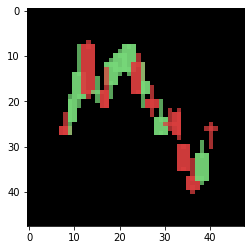

In [16]:
#plt.figure()
plt.imshow(X_train[1000])
plt.show()

candle stick chart의 예시이다.

## 2.CNN 모델링

### 1) 모델 작성

In [4]:
import tensorflow as tf
# Keras의 Functional API를 이용
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(48, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(96, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 48)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 48)        0     

### 2) 모델 학습
50 epochs 8 batch 기준

In [8]:
batch_size = 8
epochs = 50

opt = keras.optimizers.Adam(learning_rate=1.0e-4)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                 validation_split=0.2)

Epoch 1/50
3757/3757 [==============================] - 62s 9ms/step - loss: 0.6929 - accuracy: 0.5171 - val_loss: 0.6901 - val_accuracy: 0.5472
Epoch 2/50
3757/3757 [==============================] - 31s 8ms/step - loss: 0.6922 - accuracy: 0.5204 - val_loss: 0.6903 - val_accuracy: 0.5472
Epoch 3/50
3757/3757 [==============================] - 34s 9ms/step - loss: 0.6922 - accuracy: 0.5219 - val_loss: 0.6903 - val_accuracy: 0.5476
Epoch 4/50
3757/3757 [==============================] - 32s 8ms/step - loss: 0.6918 - accuracy: 0.5243 - val_loss: 0.6887 - val_accuracy: 0.5472
Epoch 5/50
3757/3757 [==============================] - 32s 8ms/step - loss: 0.6914 - accuracy: 0.5284 - val_loss: 0.6891 - val_accuracy: 0.5427
Epoch 6/50
3757/3757 [==============================] - 34s 9ms/step - loss: 0.6907 - accuracy: 0.5274 - val_loss: 0.6888 - val_accuracy: 0.5469
Epoch 7/50
3757/3757 [==============================] - 34s 9ms/step - loss: 0.6897 - accuracy: 0.5343 - val_loss: 0.6882 - val_ac

In [9]:
model.save('/content/gdrive/My Drive/Colab Notebooks/50epoch_8batch_CNN_candle_model_20stocks')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/50batch_8epoch_CNN_candle_model_20stocks/assets


학습이 완료된 모델의 features 정보를 저장한다. 

In [8]:
model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/50epoch_8batch_CNN_candle_model_20stocks')

미리 저장해둔 모델의 정보를 불러온다.

### 3) 학습 결과

In [10]:
print('## training loss and acc ##')
print('#### Train Loss ####')
print(hist.history['loss'])
print('#### Train Accuracy ####')
print(hist.history['accuracy'])
print('#### Test Loss ####')
print(hist.history['val_loss'])
print('#### Test Accuracy ####')
print(hist.history['val_accuracy'])

## training loss and acc ##
#### Train Loss ####
[0.6929029226303101, 0.692241370677948, 0.6922149658203125, 0.6918169856071472, 0.6913828253746033, 0.6907419562339783, 0.6896593570709229, 0.6892532706260681, 0.6876960396766663, 0.6860187649726868, 0.6848301887512207, 0.682387113571167, 0.6800569891929626, 0.6774872541427612, 0.6727580428123474, 0.6695982813835144, 0.6660236716270447, 0.6614773273468018, 0.6570168137550354, 0.6487888693809509, 0.6459589004516602, 0.6378540992736816, 0.6325620412826538, 0.6267483830451965, 0.6171911954879761, 0.6134446263313293, 0.6033499836921692, 0.598544180393219, 0.5924904346466064, 0.5839892625808716, 0.580379843711853, 0.5684522986412048, 0.5651406049728394, 0.5597978830337524, 0.5522246360778809, 0.543592631816864, 0.5370961427688599, 0.5321743488311768, 0.5273568034172058, 0.5196801424026489, 0.5167619585990906, 0.5099182724952698, 0.5069287419319153, 0.5014525651931763, 0.500709056854248, 0.4893698990345001, 0.48689505457878113, 0.4800583422183

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

Text(0, 0.5, 'accuracy')

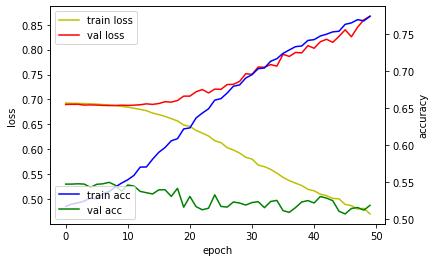

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
acc_ax.plot(hist.history['accuracy'],'b',label='train acc')
acc_ax.plot(hist.history['val_accuracy'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()


Train loss는 학습이 진행됨에 따라 줄어드는 모습을 보이지만 validation loss는 증가하는 모습을 보인다. 따라서 overfitting이 발생했음을 알 수 있다. 

In [12]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=8)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1176/1176 [==============================] - 5s 4ms/step - loss: 0.8828 - accuracy: 0.5085
## evaluation loss and_metrics ##
[0.8827871680259705, 0.5084547400474548]


### 4) 예측

In [13]:
predicted = model.predict(X_test)
predicted

array([[0.46262708],
       [0.35112864],
       [0.37561208],
       ...,
       [0.95675373],
       [0.95675373],
       [0.95675373]], dtype=float32)

In [14]:
predicted.shape

(9403, 1)

## 3.Independent stock data를 이용해 backtesting 진행

### 1) Independent stock data 수집 및 전처리

In [16]:
# 003490 : 대한항공
starting = '20100101'
ending = '20211119'
stock_code = '003490'

backtest_df = get_stock_data(starting, ending, stock_code)
backtest_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,37697,38385,37628,37837,495627
2010-01-05,37834,39141,37697,38799,1119431
2010-01-06,39210,39692,38247,38799,883706
2010-01-07,38798,38798,36733,37148,1079165
2010-01-08,37284,37559,36665,37354,556812


In [ ]:
'''
backtest_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/TSLA.csv')
backtest_df.set_index('Date', inplace=True)
backtest_df = backtest_df.drop('Adj Close', axis=1)
backtest_df = data_cleansing(backtest_df)
backtest_df.index = pd.to_datetime(backtest_df.index)
backtest_df
'''

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-16,36.529999,36.945999,36.242001,36.785999,17172000
2016-11-17,36.698002,37.897999,36.422001,37.731998,24435500
2016-11-18,38.130001,38.599998,37.000000,37.004002,26051500
2016-11-21,37.007999,37.778000,36.882000,36.903999,21805000
2016-11-22,37.167999,38.293999,36.742001,38.234001,28017000
...,...,...,...,...,...
2021-11-09,1173.599976,1174.500000,1011.520020,1023.500000,59105800
2021-11-10,1010.409973,1078.099976,987.309998,1067.949951,42802700
2021-11-11,1102.770020,1104.969971,1054.680054,1063.510010,22396600


In [17]:
seq_len = 20
dimension = 48

In [18]:
figures, labels = ohlc2cs(backtest_df, seq_len, dimension)
figures = figures/255.0
print(np.shape(labels), np.shape(figures))

Converting olhc to candlestick.
Converting olhc to candlestick finished.
(2899,) (2899, 48, 48, 3)


In [19]:
np.save('/content/gdrive/My Drive/Colab Notebooks/saved_backtest_X', figures)
np.save('/content/gdrive/My Drive/Colab Notebooks/saved_backtest_y', labels)

In [ ]:
figures = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_backtest_X.npy')
labels = np.load('/content/gdrive/My Drive/Colab Notebooks/saved_backtest_y.npy')

### 2) 학습된 모델을 이용해 다음날 종가의 상승/하락 방향 예측

In [20]:
predicted_stock = model.predict(figures)

In [21]:
predicted_stock

array([[0.40655133],
       [0.49488533],
       [0.23725583],
       ...,
       [0.642979  ],
       [0.642979  ],
       [0.642979  ]], dtype=float32)

In [22]:
backtest_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,37697,38385,37628,37837,495627
2010-01-05,37834,39141,37697,38799,1119431
2010-01-06,39210,39692,38247,38799,883706
2010-01-07,38798,38798,36733,37148,1079165
2010-01-08,37284,37559,36665,37354,556812


In [23]:
def signal(df, predict):
  i = 0
  holding = False
  매수일 = 0
  df['Signal'] = 'hold'
  df['매수가격'] = 0
  df['매도가격'] = 0
  df['거래발생'] = False
  for p in predict:
    try:
      if p > 0.5:
        if holding == False:
          df.loc[df.index[i + int(seq_len)], 'Signal'] = 'buy'
          매수일 = df.index[i + int(seq_len)]
          df.loc[df.index[i + int(seq_len)], '거래발생'] = True
          holding = True
        else:
          df.loc[df.index[i + int(seq_len)], 'Signal'] = 'hold'
      else:
        if holding == True:
          df.loc[df.index[i + int(seq_len)], 'Signal'] = 'sell'
          df.loc[df.index[i + int(seq_len)], '매수가격'] = df.loc[매수일, 'Close']
          df.loc[df.index[i + int(seq_len)], '매도가격'] = df.loc[df.index[i + int(seq_len)], 'Close'] 
          df.loc[df.index[i + int(seq_len)], '거래발생'] = True
          holding = False
        else:
          df.loc[df.index[i + int(seq_len)], 'Signal'] = 'hold'
      i+=1
    except:
      pass

매수/매도 시그널을 작성하는 함수이다. 
* 모델이 예측한 확률 > 0.5 : 매수(True)
* 모델이 예측한 확률 <= 0.5 : 매도(False)

In [24]:
signal(backtest_df, predicted_stock)

In [25]:
backtest_df.head(100)

,Open,High,Low,Close,Volume,Signal,매수가격,매도가격,거래발생
Date,,,,,,,,,
2010-01-04,37697,38385,37628,37837,495627,hold,0,0,False
2010-01-05,37834,39141,37697,38799,1119431,hold,0,0,False
2010-01-06,39210,39692,38247,38799,883706,hold,0,0,False
2010-01-07,38798,38798,36733,37148,1079165,hold,0,0,False
2010-01-08,37284,37559,36665,37354,556812,hold,0,0,False
...,...,...,...,...,...,...,...,...,...
2010-05-20,50080,51662,49048,49462,550178,hold,0,0,False
2010-05-24,49460,49598,48016,48499,756208,hold,0,0,False
2010-05-25,47053,48016,45264,48017,1120189,hold,0,0,False


### 3) Backtesting 진행

In [26]:
commision = 0.0026

def backtest(dataframe, info_print=True):
    dataframe['포트폴리오 가치변화'] = 0
    
    # backtest 기본 정보 출력
    backtest_period = len(dataframe)
    backtest_start = dataframe.index[0]
    backtest_end = dataframe.index[-1]
    if info_print==True:
        print(f'백테스트가 행해지는 기간 : {backtest_period}일\t---\t{backtest_start.date()} ~ {backtest_end.date()}')
        print('거래 발생 일수의 비율 : {}%'.format(round((dataframe['거래발생'].value_counts().loc[True].item())/len(dataframe)*100),2))
    else:
        pass
    
    # 백테스트 시작
    매매수익률 = dataframe[['매수가격', '매도가격']].loc[dataframe['Signal']=='sell'].T.pct_change().loc['매도가격']
    dataframe.loc[매매수익률.index, '포트폴리오 가치변화'] = 매매수익률.values
    수수료반영포트폴리오 = dataframe[['포트폴리오 가치변화']].loc[dataframe.loc[dataframe['Signal']==True].index]-commision
    dataframe.loc[수수료반영포트폴리오.index, '포트폴리오 가치변화'] = 수수료반영포트폴리오.values
    dataframe['포트폴리오 누적수익률'] = (dataframe['포트폴리오 가치변화']+1).cumprod()
    
    return dataframe, backtest_period, backtest_start, backtest_end

def get_benchmark_return(backtest_start, backtest_end, dataframe, portfolio_level=True):
    benchmark = stock.get_index_ohlcv_by_date(backtest_start, backtest_end, "1001")['종가'] # 1001은 코스피지수
    benchmark = benchmark.loc[dataframe.index]
    benchmark_return = benchmark/benchmark.iloc[0]
    if portfolio_level==False:
        simple_return = dataframe['Close']/dataframe['Close'].iloc[0]
        simple_return.name = '단순보유전략'
        benchmark_return.name = '벤치마크(KOSPI)'
        return pd.concat([simple_return, benchmark_return], axis=1)
    else:
        benchmark_return.name = '벤치마크(KOSPI)'
        return benchmark_return

def show_backtest_result(dataframe, benchmark_return, backtest_period):
    pd.concat([dataframe['포트폴리오 누적수익률'], benchmark_return], axis=1).plot()
    plt.show()
    
    # 1. final return
    final_return = round(dataframe['포트폴리오 누적수익률'].iloc[-1]/dataframe['포트폴리오 누적수익률'].iloc[0]*100,2)

    # 2. CAGR
    backtest_year = backtest_period / 252
    CAGR = round(((dataframe['포트폴리오 누적수익률'].iloc[-1]/dataframe['포트폴리오 누적수익률'].iloc[0])**(1/backtest_year)-1)*100,2)

    # 3. MDD
    DD_tracking = []
    for idx, val in enumerate(dataframe['포트폴리오 누적수익률'].values):
        전고점 = dataframe['포트폴리오 누적수익률'].values[:idx+1].max()
        DD_tracking.append((val-전고점)/전고점*100)

    MDD = round(min(DD_tracking),2)
    MDD발생시점 = DD_tracking.index(min(DD_tracking))
    MDD발생시점 = dataframe[['포트폴리오 누적수익률']].iloc[MDD발생시점].name.date()

    # 4. Sharpe Ratio
    # 무위험 자산의 수익률=0%로 근사
    h = 1e-5
    SHARPE_RATIO = round((dataframe['포트폴리오 가치변화']).mean()/(dataframe['포트폴리오 가치변화'].std() + h) * np.sqrt(252),2)
    print(f'최종 수익률 : {final_return}%')
    print(f'CAGR : {CAGR}%')
    print(f'MDD : {MDD}% ===> 발생시점 : {MDD발생시점}')
    print(f'Annualized 샤프지수 : {SHARPE_RATIO}')
    return CAGR, MDD, SHARPE_RATIO

In [27]:
sample_backtest, bp, bs, be = backtest(backtest_df)

백테스트가 행해지는 기간 : 2900일	---	2010-01-04 ~ 2021-11-19
거래 발생 일수의 비율 : 42%


### 4) Backtesting 결과

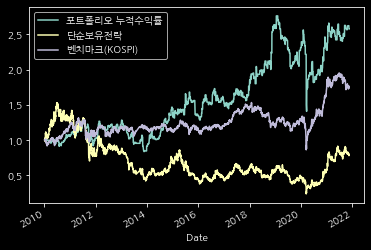

최종 수익률 : 257.66%
CAGR : 8.57%
MDD : -49.09% ===> 발생시점 : 2020-03-23
Annualized 샤프지수 : 0.45


In [31]:
benchmark_cum_return = get_benchmark_return(bs, be, sample_backtest, portfolio_level=False)
CAGR, MDD, SHARPE_RATIO = show_backtest_result(sample_backtest, benchmark_cum_return, bp)

In [34]:
# 1. 포트폴리오를 구성할 Stock Universe를 정의한다 = 리스트 안에 stock code가 들어가 있는 형태
# 주의) 꼭 리스트 형태로 줄 것!

# 2. 아래의 함수를 실행시킨다
from tqdm import tqdm

def portfolio_backtest(start_date, end_date, stock_universe):
    
    PORTFOLIO = pd.DataFrame()
    problematic_stock = []
    p = 1
    
    for stock_code in tqdm(stock_universe):
        seq_len = 20
        dimension = 48
        print('\n')
        sample = get_stock_data(start_date, end_date, stock_code)
        figures, labels = ohlc2cs(sample, seq_len, dimension)
        figures = figures/255.0
        predicted_stock = model.predict(figures)
        signal(sample, predicted_stock)
        #sample = data_cleansing(sample)

        if len(sample)!=0:
            sample_backtest, bp, bs, be = backtest(sample, info_print=False)
            PORTFOLIO = pd.concat([PORTFOLIO, sample_backtest['포트폴리오 가치변화']], axis=1)
        else:
            problematic_stock.append(stock_code)
            continue

    for ps in problematic_stock:
        stock_universe.remove(ps)

    PORTFOLIO.columns = stock_universe
    
    PORTFOLIO_정리 = pd.DataFrame()
    PORTFOLIO_정리['포트폴리오 가치변화'] = PORTFOLIO.mean(axis=1, skipna=True)
    PORTFOLIO_정리['포트폴리오 누적수익률'] = (PORTFOLIO.mean(axis=1, skipna=True)+1).cumprod()

    bs = PORTFOLIO_정리.index[0]
    be = PORTFOLIO_정리.index[-1]
    bp = len(PORTFOLIO_정리)
    benchmark_cum_return = get_benchmark_return(bs, be, PORTFOLIO_정리, portfolio_level=True)
    CAGR, MDD, SHARPE_RATIO = show_backtest_result(PORTFOLIO_정리, benchmark_cum_return, bp)
    return PORTFOLIO, PORTFOLIO_정리, CAGR, MDD, SHARPE_RATIO

### 5) Portfolio 구성 후 backtesting 진행 및 결과

  0%|          | 0/5 [00:00<?, ?it/s]



Converting olhc to candlestick.


 20%|██        | 1/5 [00:08<00:32,  8.06s/it]

Converting olhc to candlestick finished.


Converting olhc to candlestick.
Converting olhc to candlestick finished.


 40%|████      | 2/5 [00:41<01:08, 22.94s/it]



Converting olhc to candlestick.
Converting olhc to candlestick finished.


 60%|██████    | 3/5 [03:08<02:39, 79.71s/it]



Converting olhc to candlestick.
Converting olhc to candlestick finished.


 80%|████████  | 4/5 [03:59<01:08, 68.32s/it]



Converting olhc to candlestick.
Converting olhc to candlestick finished.


100%|██████████| 5/5 [06:27<00:00, 77.45s/it]


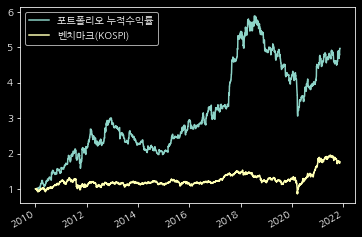

최종 수익률 : 496.67%
CAGR : 14.79%
MDD : -48.05% ===> 발생시점 : 2020-03-23
Annualized 샤프지수 : 0.75


In [36]:
starting = '20100101'
ending = '20211119'
length = 5
stocks = market_cap_df.iloc[45:50]
stock_list = np.array(stocks.index)
result = portfolio_backtest(starting, ending, stock_universe=stock_list)

In [37]:
stock_list

array(['329180', '316140', '010130', '263750', '066970'], dtype=object)

* '329180' : 현대중공업
* '316140' : 우리금융지주
* '010130' : 고려아연
* '263750' : 펄비어스
* '066970' : 엘앤에프

## 참고자료

* [https://arxiv.org/pdf/1903.12258.pdf](https://arxiv.org/pdf/1903.12258.pdf)
* [https://github.com/jason887/Using-Deep-Learning-Neural-Networks-and-Candlestick-Chart-Representation-to-Predict-Stock-Market](https://github.com/jason887/Using-Deep-Learning-Neural-Networks-and-Candlestick-Chart-Representation-to-Predict-Stock-Market)
* [https://github.com/quant4junior/algoTrade](https://github.com/quant4junior/algoTrade)
* [https://dataplay.tistory.com/36](https://dataplay.tistory.com/36)